# Krylov type of methods for solving Helmholtz equation in 2D


Helmholtz equation with complex frequency with Dirichlet boundary condition

$$-\Delta u(x,y) - (\omega^2 + \imath \eta) u(x,y) = f(x,y), \quad (x,y)\in \Omega=[0,1]^2,\quad u\vert_{\partial\Omega} = 0$$

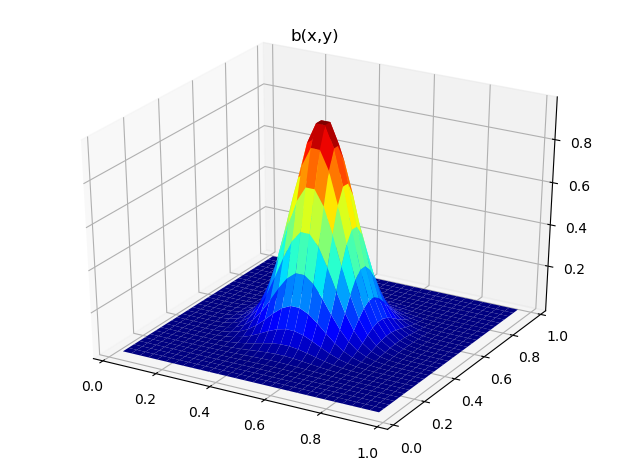

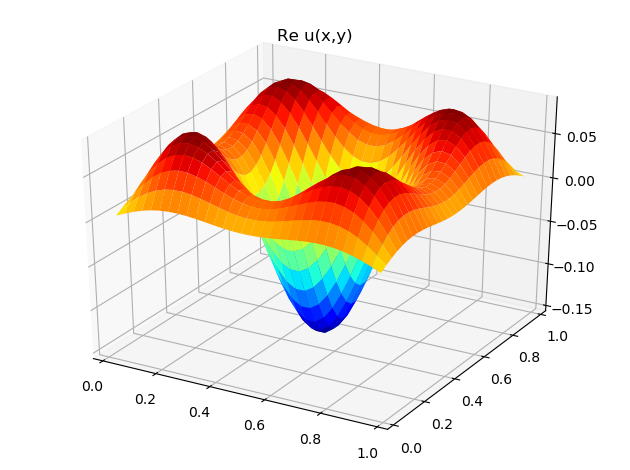

PyObject Text(0.5,0.92,'Re u(x,y)')

In [21]:
using LinearAlgebra
using SparseArrays

# Setup for the matrix
N = 30
h = 1.0 / (N+1)
x1d = collect(1:N)*h
omega = 10.0
eta = 0.1
sI_N = sparse(1.0I,N,N)

# Full 2D Laplacian on the entire square
A1D = 1.0/h^2*spdiagm(-1=>-ones(N-1),0=>2.0*ones(N),1=>-ones(N-1))
A2D = kron(A1D,sI_N)+kron(sI_N,A1D)
A2D = A2D - (omega^2+im*eta)*sparse(1.0I,N*N,N*N)

sigma = 0.1
b = [exp.(-((x1d[i]-0.5)^2 + (x1d[j]-0.5)^2) / (2*sigma^2)) for i = 1 : N, j = 1 : N] 
b = reshape(b,N*N)
uexact = A2D\b
x0 = zeros(N*N)

using PyPlot
figure(1)
surf(x1d,x1d,reshape(b,N,N),edgecolors="none",cmap=ColorMap("jet"),shade="true")
title("b(x,y)")

figure(2)
surf(x1d,x1d,reshape(real(uexact),N,N),edgecolors="none",cmap=ColorMap("jet"),shade="true")
title("Re u(x,y)")

3×3 Array{Complex{Float64},2}:
 -1.28952-0.1im  97.4431-1.87321e-18im  -4.15058e-14-2.14582e-17im
  97.4431+0.0im  186.186-0.1im               187.632-2.50888e-17im
      0.0+0.0im  187.632+0.0im               360.056-0.1im        

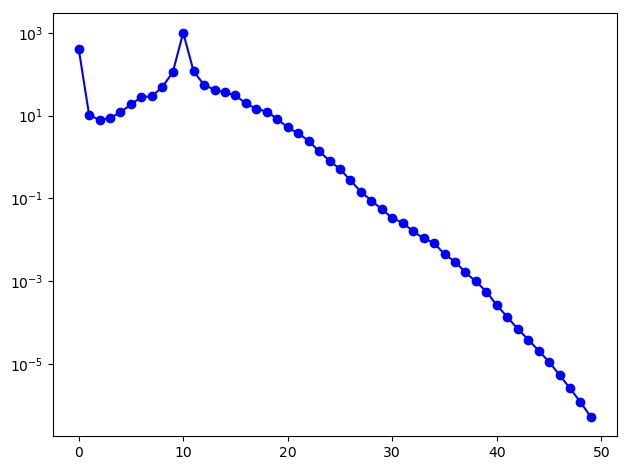

Error ||u-uexact||_2 = 2.4418362299068683e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb1a7bfa860>

In [33]:
# FOM method.
# This is a demonstration implementation and there is no restart
# This is also the most inefficient implementation. This is essentially CG.

function FOMFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    V = zeros(ComplexF64,N,maxiter)
    H = zeros(ComplexF64,maxiter,maxiter-1)
    Av = zeros(ComplexF64,N)
    nrmr0 = norm(r0)
    V[:,1] = r0 / nrmr0
    errhist = zeros(maxiter)
    
    k = 0
    while ( k < maxiter - 1)
        k += 1
        Av = A*V[:,k]
        # Modified Gram-Schmidt for orthogonalization
        for j = 1 : k
            H[j,k] = dot(V[:,j],Av)
            Av -= H[j,k] * V[:,j]
        end
        H[k+1,k] = norm(Av)

        e1 = zeros(k)
        e1[1] = 1.0
        b1 = e1*nrmr0
        y = H[1:k,1:k]\b1
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = sqrt(real(r'*r))
        errhist[k] = nrmrnew
        if(abs(H[k+1,k])<1e-12 || nrmrnew < tol)
            break
        end        
        V[:,k+1] = Av/H[k+1,k]
    end
    errhist = errhist[1:k]
    
    # Show symmetry pattern
    display(H[1:3,1:3])
    
    return x,errhist
end

u,errhist = FOMFull(A2D,b,x0,1e-6,100)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")

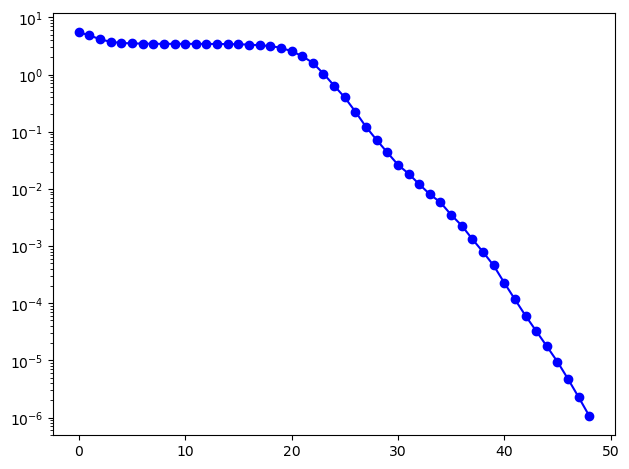

Error ||u-uexact||_2 = 7.031806094651098e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb1a7813400>

In [27]:
# GMRES method.
# This is a demonstration implementation and there is no restart
# This is also the most inefficient implementation, in the sense
# that the QR is done at each iteration. 

function gmresFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    V = zeros(ComplexF64,N,maxiter)
    H = zeros(ComplexF64,maxiter,maxiter-1)
    Av = zeros(ComplexF64,N)
    nrmr0 = norm(r0)
    V[:,1] = r0 / nrmr0
    errhist = zeros(maxiter)
    
    k = 0
    while ( k < maxiter - 1 )
        k += 1
        Av = A*V[:,k]
        # Modified Gram-Schmidt for orthogonalization
        for j = 1 : k
            H[j,k] = dot(V[:,j],Av)
            Av -= H[j,k] * V[:,j]
        end
        H[k+1,k] = norm(Av)
        V[:,k+1] = Av/H[k+1,k]

        Q,R=qr(H[1:k+1,1:k])
        Q = Matrix(Q) # Needed to the "thin" QR factor
        y = zeros(k,1)
        b1 = vec(conj(Q[1,:]))*nrmr0
        y = R\b1
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = sqrt(real(r'*r))
        errhist[k] = nrmrnew
        if(abs(H[k+1,k])<1e-12 || nrmrnew < tol)
            break
        end     
    end
    errhist = errhist[1:k]
    return x,errhist
end


u,errhist = gmresFull(A2D,b,x0,1e-6,50)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")

4×4 Array{Complex{Float64},2}:
          1.0+0.0im          …   5.46926e-16-2.5633e-21im 
 -4.02984e-17+1.20638e-19im     -1.51788e-16+1.25889e-19im
 -1.42898e-16-1.01325e-19im     -7.73687e-16+2.57739e-19im
  3.73562e-16-3.13656e-20im              1.0-1.31054e-33im

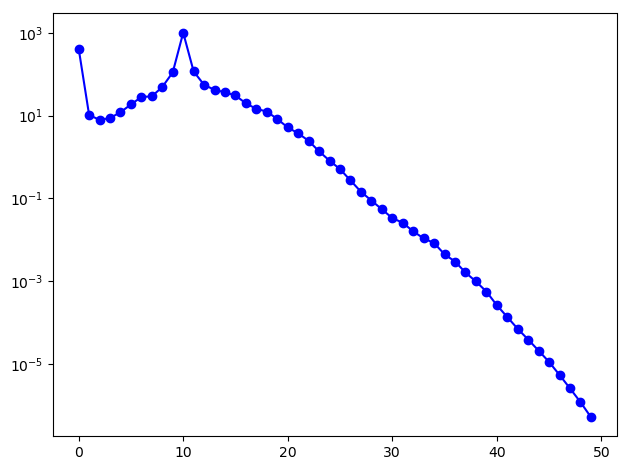

Error ||u-uexact||_2 = 2.441719332499069e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb1a7bab438>

In [30]:
# BiCG
# This is a demonstration implementation and there is no restart
# This is a very inefficient implementation.
# This implementation does fully respect complex arithmetic

# NOTE: This uses twice as many matvec!


function BiCGFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    V = zeros(ComplexF64,N,maxiter)
    W = zeros(ComplexF64,N,maxiter)
    H = zeros(ComplexF64,maxiter,maxiter-1)
    Av  = zeros(ComplexF64,N)
    Atw = zeros(ComplexF64,N)
    nrmr0 = norm(r0)
    V[:,1] = r0 / nrmr0
    W[:,1] = conj(V[:,1])
    e1 = zeros(maxiter)
    e1[1] = 1.0
    b1 = e1*nrmr0
    T = spzeros(ComplexF64,maxiter,maxiter)
    
    errhist = zeros(maxiter)
    
    k = 0
    while( k < maxiter - 1)
        k += 1
        Av = A*V[:,k]
        # In practice it needs a functional handle computing A' x
        Atw = A'*W[:,k]
        # Bi-directional Lanczos
        T[k,k] = dot(W[:,k],Av)
        if( k == 1 )
            Av  -= T[k,k] * V[:,k]
            Atw -= conj(T[k,k]) * W[:,k]
        else
            Av  -= T[k,k] * V[:,k] + T[k-1,k] * V[:,k-1]
            Atw -= conj(T[k,k]) * W[:,k] + conj(T[k,k-1]) * W[:,k-1]
        end
        tt = dot(Atw,Av)
        T[k+1,k] = sqrt(abs(tt))
        T[k,k+1] = tt / T[k+1,k]
        V[:,k+1] = Av / T[k+1,k]
        W[:,k+1] = Atw / conj(T[k,k+1])

        
        y = T[1:k,1:k]\b1[1:k]
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = sqrt(real(r'*r))
        errhist[k] = nrmrnew
        if(abs(T[k+1,k])<1e-12 || nrmrnew < tol)
            break
        end        
    end
    errhist = errhist[1:k]
    
    display((Matrix(W[:,1:4]'*V[:,1:4])))
    
    return x,errhist
end

u,errhist = BiCGFull(A2D,b,x0,1e-6,100)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")

4×4 Array{Complex{Float64},2}:
          1.0+0.0im          …   5.46926e-16-2.5633e-21im 
 -4.02984e-17+1.20638e-19im     -1.51788e-16+1.25889e-19im
 -1.42898e-16-1.01325e-19im     -7.73687e-16+2.57739e-19im
  3.73562e-16-3.13656e-20im              1.0-1.31054e-33im

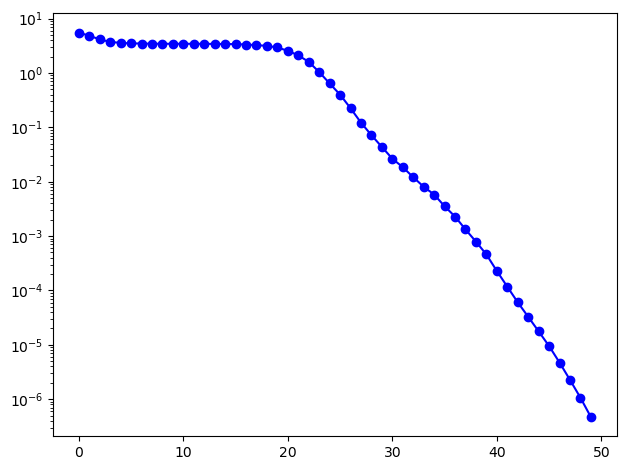

Error ||u-uexact||_2 = 3.0301652884210204e-10


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb1a7c74fd0>

In [32]:
# QMR
# This is a demonstration implementation and there is no restart
# This is a very inefficient implementation.
# This implementation does fully respect complex arithmetic

# NOTE: This uses twice as many matvec!

function QMRFull(A,b,x0,tol=1e-5,maxiter=1000)
    N = length(b)
    x = copy(x0)
    r0 = b - A * x
    # Arnoldi procedure
    V = zeros(ComplexF64,N,maxiter)
    W = zeros(ComplexF64,N,maxiter)
    H = zeros(ComplexF64,maxiter,maxiter-1)
    Av  = zeros(ComplexF64,N)
    Atw = zeros(ComplexF64,N)
    nrmr0 = norm(r0)
    V[:,1] = r0 / nrmr0
    W[:,1] = conj(V[:,1])
    e1 = zeros(maxiter)
    e1[1] = 1.0
    b1 = e1*nrmr0
    T = spzeros(ComplexF64,maxiter,maxiter)
    
    errhist = zeros(maxiter)
    
    k = 0
    while( k < maxiter - 1)
        k += 1
        Av = A*V[:,k]
        # In practice it needs a functional handle computing A' x
        Atw = A'*W[:,k]
        # Bi-directional Lanczos
        T[k,k] = dot(W[:,k],Av)
        if( k == 1 )
            Av  -= T[k,k] * V[:,k]
            Atw -= conj(T[k,k]) * W[:,k]
        else
            Av  -= T[k,k] * V[:,k] + T[k-1,k] * V[:,k-1]
            Atw -= conj(T[k,k]) * W[:,k] + conj(T[k,k-1]) * W[:,k-1]
        end
        tt = dot(Atw,Av)
        T[k+1,k] = sqrt(abs(tt))
        T[k,k+1] = tt / T[k+1,k]
        V[:,k+1] = Av / T[k+1,k]
        W[:,k+1] = Atw / conj(T[k,k+1])

        Q,R=qr(Matrix(T[1:k+1,1:k]))
        Q = Matrix(Q)
        b1 = vec(conj(Q[1,:]))*nrmr0
        y = R\b1
        x = x0 + V[:,1:k]*y
        r = A*x-b
        nrmrnew = sqrt(real(r'*r))
        errhist[k] = nrmrnew
        if(abs(T[k+1,k])<1e-12 || nrmrnew < tol)
            break
        end        
    end
    errhist = errhist[1:k]
    
    display((Matrix(W[:,1:4]'*V[:,1:4])))
    
    return x,errhist
end

u,errhist = QMRFull(A2D,b,x0,1e-6,100)
println("Error ||u-uexact||_2 = ", norm(u-uexact))
figure(1)
semilogy(errhist,"b-o")